In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Prashant covid/Dataset COVID 19/'

Mounted at /content/drive


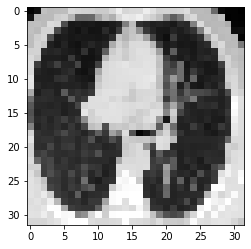

In [ ]:
import os, time, datetime
import numpy as np
import cv2
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from os import listdir
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
pca = PCA(n_components=32)

ImSize=32;
dim=1;
i=0
x_train=[]
y_train=[]

for folder in os.listdir(path):
 
  if(folder.endswith('.h5')):
    continue;
  i=i+1;
  for  images in os.listdir(path+folder):
    if images.endswith(".jpg") or images.endswith(".bmp") or images.endswith(".png") or images.endswith(".jpeg"):
      Img = np.array(imread(path+folder+'/'+images))
      Img = rgb2gray(Img)
      Img=cv2.resize(Img, (ImSize, ImSize)) 
      plt.imshow(Img,cmap='gray') 
      Img = pca.fit_transform(Img);                  
      x_train.append(Img)
      y_train.append(i)
            
x_train=np.array(x_train)
y_train=np.array(y_train)       

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
y_train1=y_train-1;
trainX = x_train.reshape((x_train.shape[0], ImSize, ImSize, dim))
trainY=to_categorical(y_train1)
TrainX=trainX.astype('float32')

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(ImSize, ImSize, dim)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(trainX, trainY, epochs=60, batch_size=64, validation_data=(trainX, trainY), verbose=0)
_, acc = model.evaluate(trainX, trainY, verbose=0)
print('> %.3f' % (acc * 100.0))
#model.save(path+'CNNModel.h5')
	 

> 99.500


In [ ]:
EPOCHS = 2
SIZE=ImSize
N_ch=dim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19

def build_vgg():
    vgg = VGG19(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)    
    x = vgg(x)    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
    model = Model(input,output)    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

modelvgg = build_vgg()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('VGG19.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) 

datagen.fit(TrainX)
BATCH_SIZE=64
hist = modelvgg.fit(datagen.flow(TrainX, trainY, batch_size=BATCH_SIZE),
               steps_per_epoch=TrainX.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=0,
               callbacks=[annealer, checkpoint],
               validation_data=(TrainX, trainY))  
  
#modelvgg.save(path+'VggModel.h5')

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                              

In [ ]:
def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(13,8))
  #plot accuracy function
  plt.subplot(221)
  plt.plot(history.history['accuracy'],'g',label="Accuracy")
  plt.plot(history.history['val_accuracy'],'b',label="Validation_Accuracy")
  plt.title("Accuracy Performance")
  plt.ylabel("accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

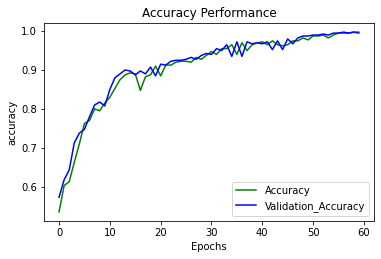

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)    
    x = resnet50(x)    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = 'softmax', name='root')(x)
    model = Model(input,output)    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


modelres = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(TrainX)    
hist = modelres.fit_generator(datagen.flow(TrainX, trainY, batch_size=BATCH_SIZE),
               steps_per_epoch=TrainX.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(TrainX, trainY))

#modelres.save(path+'ResModel.h5')


94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                            

In [ ]:
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

def build_densenet():
    densenet = ResNet50(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)    
    x = densenet(x)    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = 'softmax', name='root')(x)
    model = Model(input,output)    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


modelres = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('densenet.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(TrainX)    
hist = modelres.fit_generator(datagen.flow(TrainX, trainY, batch_size=BATCH_SIZE),
               steps_per_epoch=TrainX.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(TrainX, trainY))

modelres.save(path+'DensenetModel.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0   

In [ ]:
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

def build_resnet101():
    resnet101 = ResNet101(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)    
    x = resnet101(x)    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = 'softmax', name='root')(x)
    model = Model(input,output)    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


modelres = build_resnet101()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('resnet101.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(TrainX)    
hist = modelres.fit_generator(datagen.flow(TrainX, trainY, batch_size=BATCH_SIZE),
               steps_per_epoch=TrainX.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(TrainX, trainY))

modelres.save(path+'resModel101.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0   

In [ ]:
from keras.models import load_model

model1 = load_model(path+'CNNModel.h5')
model2 = load_model(path+'ResModel.h5')
model3 = load_model(path+'VggModel.h5')
model4 = load_model(path+'DensenetModel.h5')
model5 = load_model(path+'resModel101.h5')
# Horizontal Voting Concept and 
EnsembleModel = list()
EnsembleModel.append(model1)
EnsembleModel.append(model2)
EnsembleModel.append(model3)
EnsembleModel.append(model4)
EnsembleModel.append(model5)
from sklearn import metrics
Y_true = np.argmax(trainY, axis=1)
Ref=0;
final_model=[];
for ln in EnsembleModel:
  EY_pred = ln.predict(TrainX)
  EY_pred = np.argmax(EY_pred, axis=1)
  GenAcc=metrics.accuracy_score(EY_pred,Y_true)
  if GenAcc>Ref:
    Ref=GenAcc
    final_model=ln


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

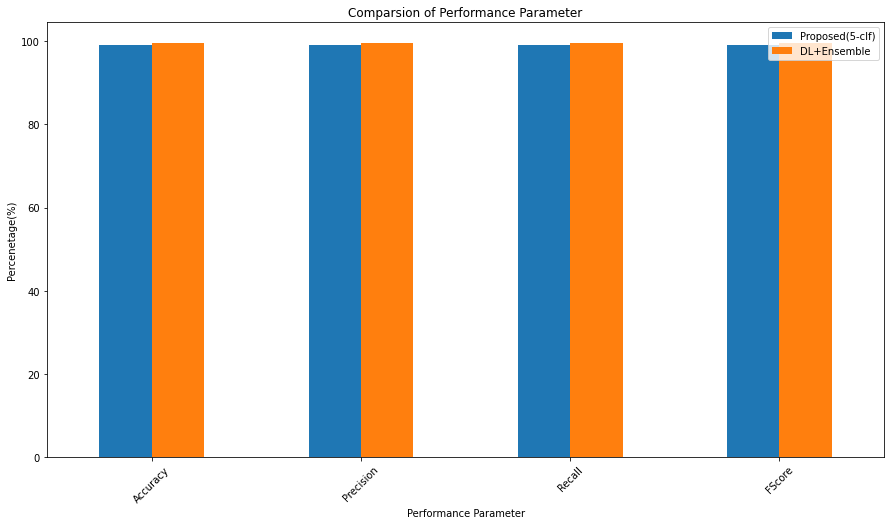

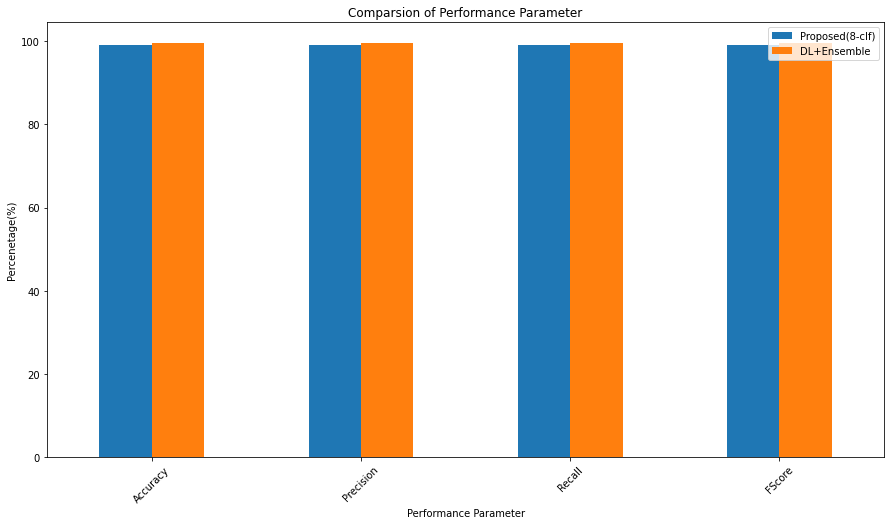

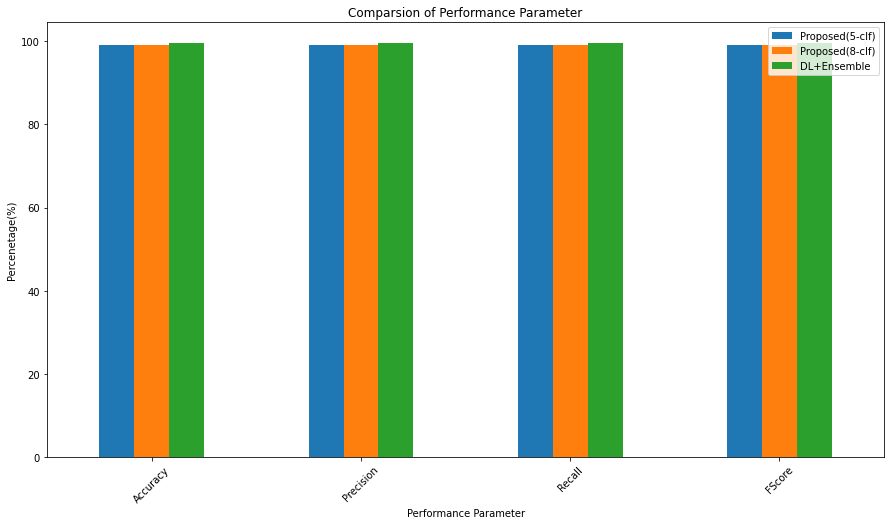

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
from sklearn import metrics

Y_true = np.argmax(trainY, axis=1)
fY_pred = final_model.predict(TrainX)
fY_pred = np.argmax(fY_pred, axis=1)

ACC=metrics.accuracy_score(fY_pred,Y_true)*100
P=metrics.precision_score(fY_pred,Y_true,average='macro')*100
R=metrics.recall_score(fY_pred,Y_true,average='macro')*100
F1=metrics.f1_score(fY_pred,Y_true)*100


plotdata1 = pd.DataFrame({
    "Proposed(5-clf)":[98.99,99.02,98.97,98.99],    
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata1.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


plotdata2 = pd.DataFrame({
    "Proposed(8-clf)":[98.99,98.98,99.00,98.99],    
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata2.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


plotdata = pd.DataFrame({
    "Proposed(5-clf)":[98.99,99.02,98.97,98.99],
    "Proposed(8-clf)":[98.99,98.98,99.00,98.99],
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


In [ ]:
print(plotdata)

           Proposed(5-clf)  Proposed(8-clf)  DL+Ensemble
Accuracy             98.99            98.99    99.500000
Precision            99.02            98.98    99.500000
Recall               98.97            99.00    99.504950
FScore               98.99            98.99    99.497487


In [ ]:
# from keras.models import load_model

# model1 = load_model(path+'CNNModel.h5')
# model2 = load_model(path+'ResModel.h5')
# model3 = load_model(path+'VggModel.h5')
# # Horizontal Voting Concept and 
# EnsembleModel = list()
# EnsembleModel.append(model1)
# EnsembleModel.append(model2)
# EnsembleModel.append(model3)

# from sklearn import metrics
# Y_true = np.argmax(trainY, axis=1)
# Ref=0;
# final_model=[];
# for ln in EnsembleModel:
#   EY_pred = ln.predict(TrainX)
#   EY_pred = np.argmax(EY_pred, axis=1)
#   GenAcc=metrics.accuracy_score(EY_pred,Y_true)
#   if GenAcc>Ref:
#     Ref=GenAcc
#     final_model=ln


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

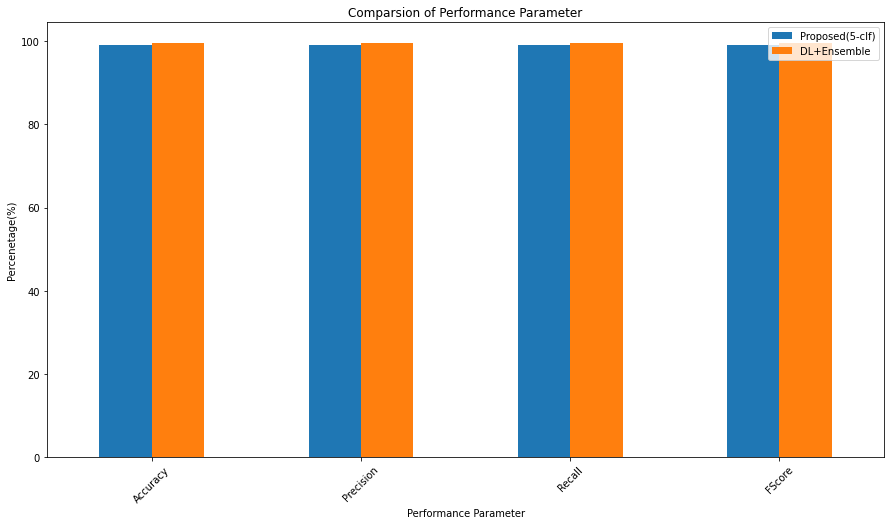

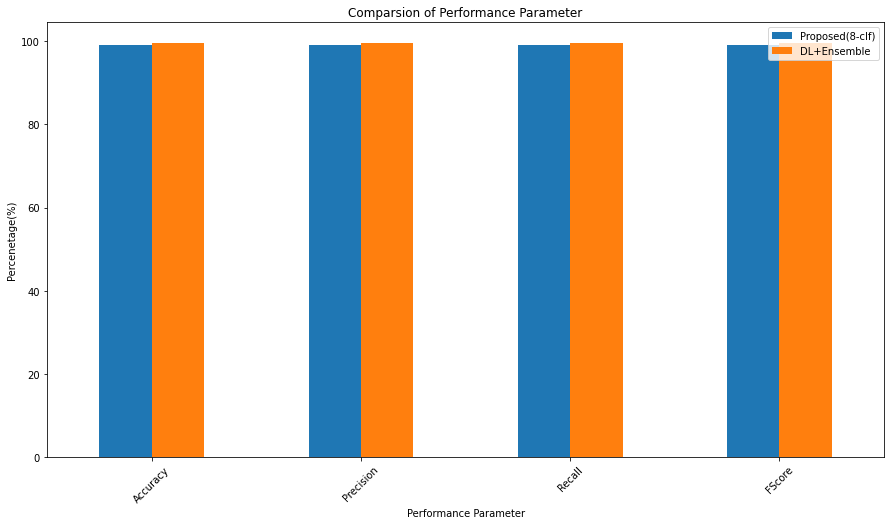

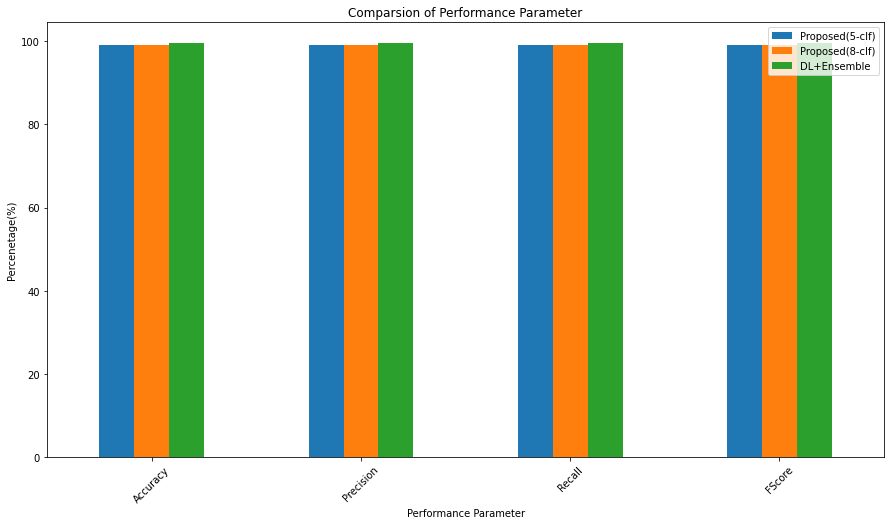

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import load_model
from sklearn import metrics

Y_true = np.argmax(trainY, axis=1)
fY_pred = final_model.predict(TrainX)
fY_pred = np.argmax(fY_pred, axis=1)

ACC=metrics.accuracy_score(fY_pred,Y_true)*100
P=metrics.precision_score(fY_pred,Y_true,average='macro')*100
R=metrics.recall_score(fY_pred,Y_true,average='macro')*100
F1=metrics.f1_score(fY_pred,Y_true)*100


plotdata1 = pd.DataFrame({
    "Proposed(5-clf)":[98.99,99.02,98.97,98.99],    
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata1.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


plotdata2 = pd.DataFrame({
    "Proposed(8-clf)":[98.99,98.98,99.00,98.99],    
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata2.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


plotdata = pd.DataFrame({
    "Proposed(5-clf)":[98.99,99.02,98.97,98.99],
    "Proposed(8-clf)":[98.99,98.98,99.00,98.99],
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)


In [ ]:
print(plotdata)

           Proposed(5-clf)  Proposed(8-clf)  DL+Ensemble
Accuracy             98.99            98.99    99.500000
Precision            99.02            98.98    99.500000
Recall               98.97            99.00    99.504950
FScore               98.99            98.99    99.497487


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

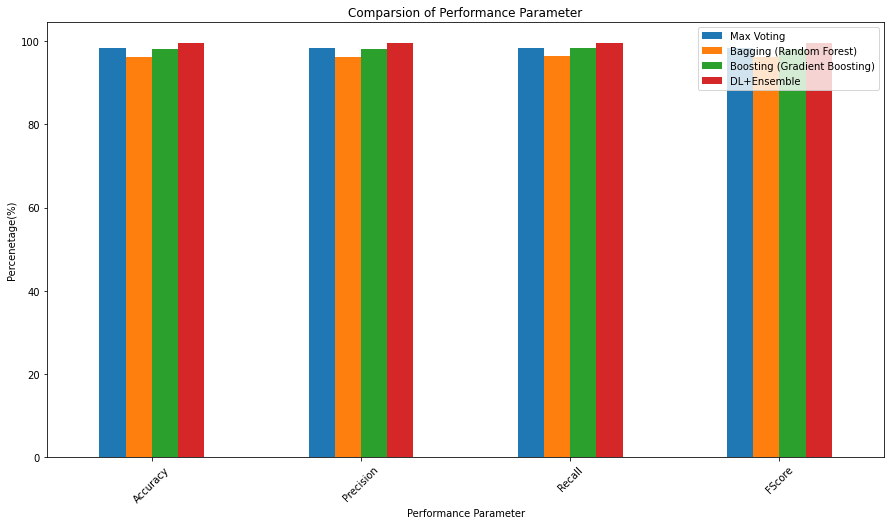

In [ ]:
plotdata2 = pd.DataFrame({
    "Max Voting":[98.39,98.37,98.40,98.39],
    "Bagging (Random Forest)":[96.18,96.26,96.32,96.18],
    "Boosting (Gradient Boosting)":[98.19,98.17,98.25,98.19],
    "DL+Ensemble":[ACC,P,R,F1]},
    index=["Accuracy", "Precision", "Recall", "FScore"])
plotdata2.plot(kind="bar",figsize=(15, 8))
plt.title("Comparsion of Performance Parameter")
plt.xlabel("Performance Parameter")
plt.ylabel("Percenetage(%)")
plt.xticks(rotation=45)

In [ ]:
print(plotdata2)

           Max Voting  Bagging (Random Forest)  Boosting (Gradient Boosting)  \
Accuracy        98.39                    96.18                         98.19   
Precision       98.37                    96.26                         98.17   
Recall          98.40                    96.32                         98.25   
FScore          98.39                    96.18                         98.19   

           DL+Ensemble  
Accuracy     99.500000  
Precision    99.500000  
Recall       99.504950  
FScore       99.497487  


Text(0.5, 34.43999999999998, 'Predicted')

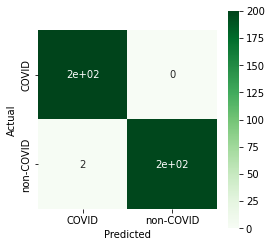

In [ ]:
disease_types=['COVID', 'non-COVID']
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_true, fY_pred)
plt.figure(figsize=(4, 4))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=10)
ax.set_xlabel('Predicted', fontsize=10)